- **Importation**

In [1]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import cupy as cp
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CONTENT_PATH_RSV = os.path.join("content", "sim.npy")
RESULT_PATH_RSV = os.path.join("..", "result", "sim.npy")
CONTENT_PATH_RSV_DENSE = os.path.join("content", "sim_d.png")

In [3]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [4]:
dataframe = pd.read_csv(os.path.join("content", "clean_tweet.csv"), encoding="latin-1")

- **TF-IDF**

In [5]:
vectorizer = TfidfVectorizer(lowercase=False, sublinear_tf=True, dtype=np.float32)
vectors = vectorizer.fit_transform(dataframe["text"] )

- **Calcule de similitude mots-mots** 

Dans cette partie on calcule le similitude entre les mots en uilisant le cosinus entre les vecteurs trouvés en uilisant l'index **TF-IDF**. Il a deux version de **RSV** un avec **GPU** en utilisant <code>cupy</code> une autre version sans .

Pour problème de memoire de la **GPU** on effectue le calcule sur chaque block de l'index **TF-IDF** 

In [6]:
if "cp" in globals():
    def SIM_GPU(T1, T2):
        sim = cp.dot(T1, T2.T)
        return sim

    def SIM2_GPU(T1, T2):
        return cp.sqrt(cp.power(T1,2).sum(axis=1).reshape(T1.shape[0], 1))*cp.sqrt(cp.power(T2,2).sum(axis=1).reshape(T2.shape[0], 1).T)

    def SIM(tf_idf_matrix, d=2, dtype=np.float16):
        m = tf_idf_matrix.shape[0]//d
        mm = tf_idf_matrix.shape[0]%d
        sim = np.zeros((tf_idf_matrix.shape[0], tf_idf_matrix.shape[0]), dtype=dtype)
        print("Allocation success")
        for i in tqdm(range(d)):
            for j in range(d):
                with cp.cuda.Device(0):
                    T1 = cp.asarray(tf_idf_matrix[i*m:(i+1)*m+(i+1==d)*mm, 0:tf_idf_matrix.shape[1]], dtype=cp.float32)
                    T2 = cp.asarray(tf_idf_matrix[j*m:(j+1)*m+(j+1==d)*mm, 0:tf_idf_matrix.shape[1]], dtype=cp.float32)
                    sim[i*m:(i+1)*m+(i+1==d)*mm, j*m:(j+1)*m+(j+1==d)*mm] = cp.asnumpy(SIM_GPU(T1, T2)/SIM2_GPU(T1, T2))
                    mempool.free_all_blocks()
                    pinned_mempool.free_all_blocks()
        return np.nan_to_num(sim)
else :
    def SIM(index):
        T1 = np.sqrt(np.power(index,2).sum(axis=1).reshape(index.shape[0], 1))
        return np.dot(index, index.T)/(T1*T1.T)

In [7]:
%%time
if "cp" in globals():
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

sim = SIM(np.asarray(vectors.todense().T, dtype=np.float16).T, d=10)

Allocation success


100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


CPU times: total: 2min 58s
Wall time: 3min 5s


In [8]:
zero_rows = []
for i in range(sim.shape[0]):
    adding = False
    for j in range(sim.shape[1]):
        if i != j and sim[i, j] != 0:
            adding = True
            break
    if not adding:
        zero_rows.append(i)
if len(zero_rows):
    sim = np.delete(sim, zero_rows, axis=0) 
    sim = np.delete(sim, zero_rows, axis=1) 

In [9]:
np.save(CONTENT_PATH_RSV, sim, allow_pickle=False)
np.save(RESULT_PATH_RSV, sim, allow_pickle=False)

- **Les mots les plus similaires**

On applique une convolution sur la matrice de similitude avec un filtre de 1 de taille (5000, 5000) avec un strides de (5000, 5000), puis avec la matrice de <code>sn.heatmap</code> , on cherche le bloc ayant la plus grand valeur, representant le bloc de la matrice **RSV** qui contient les mots les plus similaires.

In [10]:
strides = (5000, 5000)

In [11]:
def cal_conv(A, strides):
    res1 = A.shape[0]%strides[0]
    res2 = A.shape[1]%strides[1]
    output_shape = int((A.shape[0] - res1)/strides[0] + (res1!=0)) , int((A.shape[1] - res2)/strides[1] + (res2!=0))
    output = cp.zeros(output_shape, dtype=cp.float32)
    
    for i in tqdm(range(output_shape[0])):
        for j in range(output_shape[1]):
            output[i, j] = cp.asarray(A[i*strides[0]: (i+1)*strides[0]+(i==output_shape[0]-1)*res1,
                                        j*strides[1]: (j+1)*strides[1]+(j==output_shape[1]-1)*res2], dtype=cp.float32).sum()
    return cp.asnumpy(output*100)/A.sum()

In [12]:
sim2 = np.where(sim != 0, 1, 0)
np.fill_diagonal(sim2, 0)


In [13]:
%%time
output = cal_conv(sim2, strides)

100%|██████████| 12/12 [00:34<00:00,  2.84s/it]


CPU times: total: 26 s
Wall time: 35.8 s


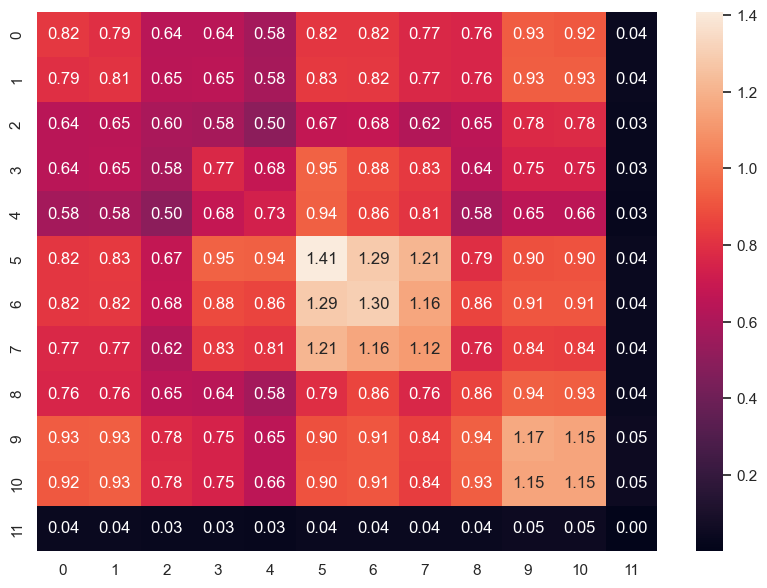

In [14]:
plt.figure(figsize=(10,7))
sn.set(font_scale=1) 
sn.heatmap(output, annot=True,  fmt = '.2f') # font size
plt.savefig(CONTENT_PATH_RSV_DENSE)
plt.show()

Les mots qui on le plus de similarité sont les mots dans l'interval 25000 et 30000.

In [15]:
i =np.unravel_index(np.argmax(output), output.shape)[0].squeeze()
voc_sim = pd.DataFrame({"vocabulaire": vectorizer.get_feature_names_out()})[i*strides[0]:(i+1)*strides[0]]
voc_sim

,vocabulaire
25000,numerologynow
25001,numerous
25002,nunes
25003,nunez
25004,nunn
...,...
29995,ritual
29996,ritz
29997,rival
29998,rivalofelmblock


In [16]:
voc_sim.to_csv(os.path.join("content", "The_most_similar_words_in_the_corpus.csv"), index=False)